## Database setup and initialization

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time
import psycopg2
from psycopg2.extras import execute_values

# Load the Spotify dataset
data = pd.read_csv('spotify_dataset.csv', header=0)

# Basic data exploration
print(f"Dataset shape: {data.shape}")
display(data.head())

# Select relevant features for vector representation
song_features = data.columns

# Extract features and target variable
features = data[song_features].values
liked = data['liked'].values if 'liked' in data.columns else None

# Standardize features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

# Function to connect to PostgreSQL
def connect_to_postgres():
    conn = psycopg2.connect(
        host="localhost",
        database="music_vectors_db",
        user="postgres",
        password="postgres123"
    )
    return conn

# Create database and setup pgvector
def setup_database():
    # Connect to the database
    conn = connect_to_postgres()
    cursor = conn.cursor()

    # Execute init.sql file
    with open('init.sql', 'r') as init_file:
        cursor.execute(init_file.read())
    
    conn.commit()
    cursor.close()
    conn.close()
    
    print("Database setup complete")

# Insert data into pgvector database
def insert_data_to_pgvector():
    conn = connect_to_postgres()
    cursor = conn.cursor()
    
    # Clear existing data
    cursor.execute("TRUNCATE music_vectors")
    
    # Prepare data for insertion
    data_to_insert = [(f.tolist(),) for f in features_standardized]
    
    # Insert data in batches
    execute_values(
        cursor,
        "INSERT INTO music_vectors (features) VALUES %s",
        data_to_insert,
        template="(%s)"
    )
    
    conn.commit()
    cursor.close()
    conn.close()
    
    print(f"Inserted {len(data_to_insert)} records into pgvector database")


connect_to_postgres()
setup_database()
insert_data_to_pgvector()

Dataset shape: (195, 14)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,liked
0,0.803,0.6240,7,-6.764,0,0.0477,0.451,0.000734,0.1000,0.6280,95.968,304524,4,0
1,0.762,0.7030,10,-7.951,0,0.3060,0.206,0.000000,0.0912,0.5190,151.329,247178,4,1
2,0.261,0.0149,1,-27.528,1,0.0419,0.992,0.897000,0.1020,0.0382,75.296,286987,4,0
3,0.722,0.7360,3,-6.994,0,0.0585,0.431,0.000001,0.1230,0.5820,89.860,208920,4,1
4,0.787,0.5720,1,-7.516,1,0.2220,0.145,0.000000,0.0753,0.6470,155.117,179413,4,1


Database setup complete
Inserted 195 records into pgvector database


## PCA Visualization

PCA explained variance ratio: [0.31148714 0.13533981]
Total variance explained: 0.4468269493017223


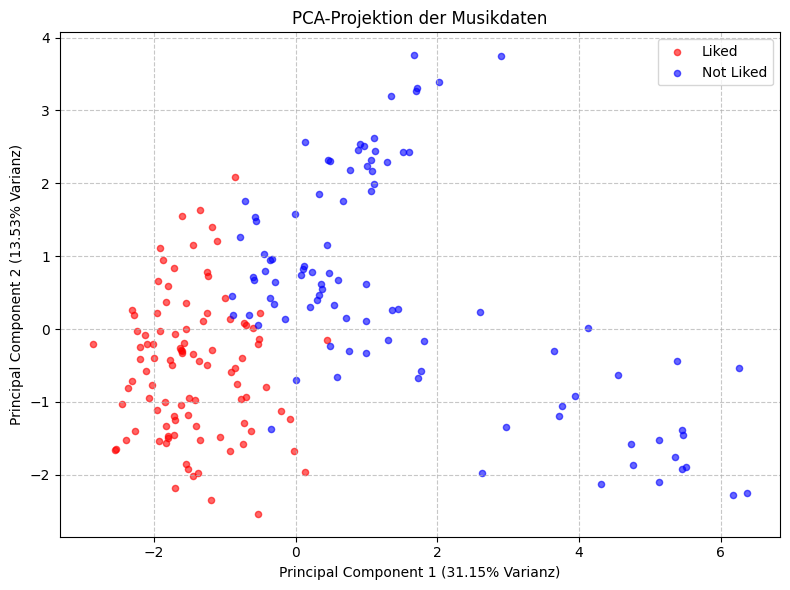


PCA Loadings:
                       PC1       PC2
danceability     -0.365448 -0.263611
energy           -0.287791  0.523091
key              -0.012096  0.193376
loudness         -0.377983  0.310844
mode              0.009612 -0.092453
speechiness      -0.260287 -0.295518
acousticness      0.287671 -0.463158
instrumentalness  0.386928  0.173710
liveness         -0.012048  0.236684
valence          -0.302091 -0.015152
tempo            -0.232009 -0.035324
duration_ms       0.210979  0.178345
time_signature   -0.182744 -0.094117
liked            -0.342281 -0.290062


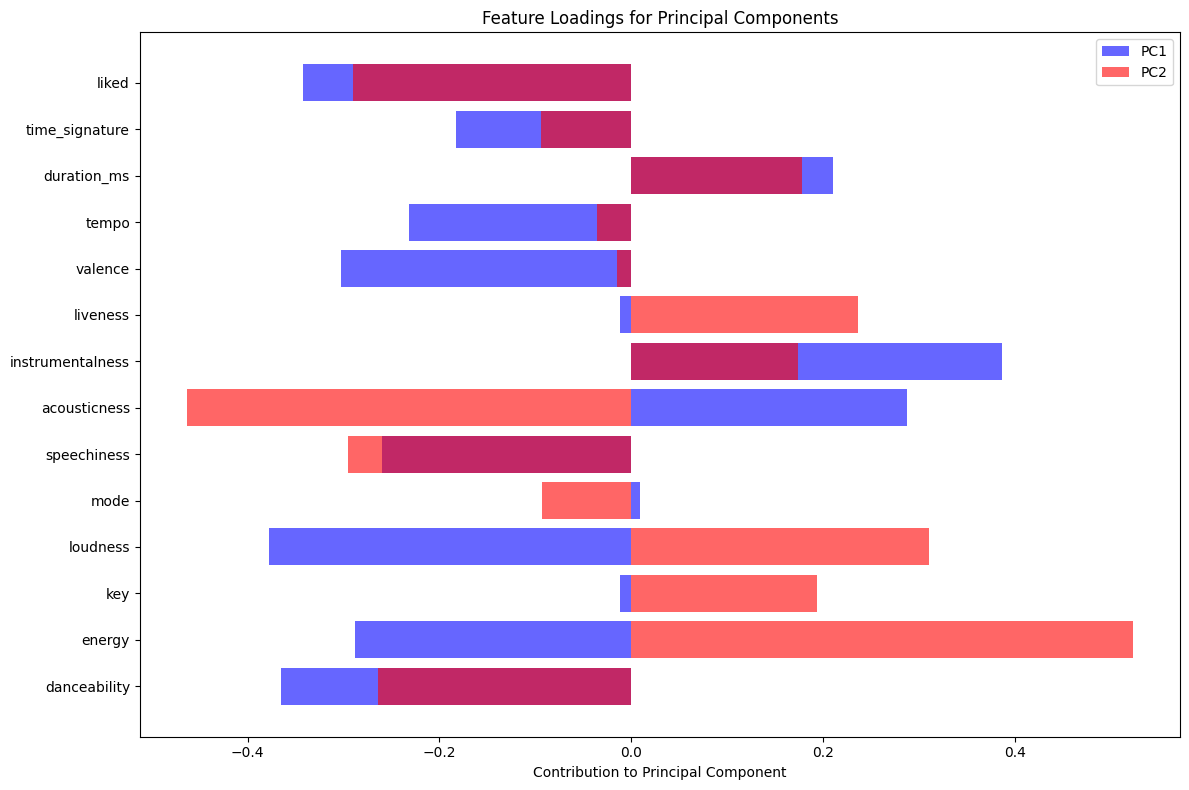

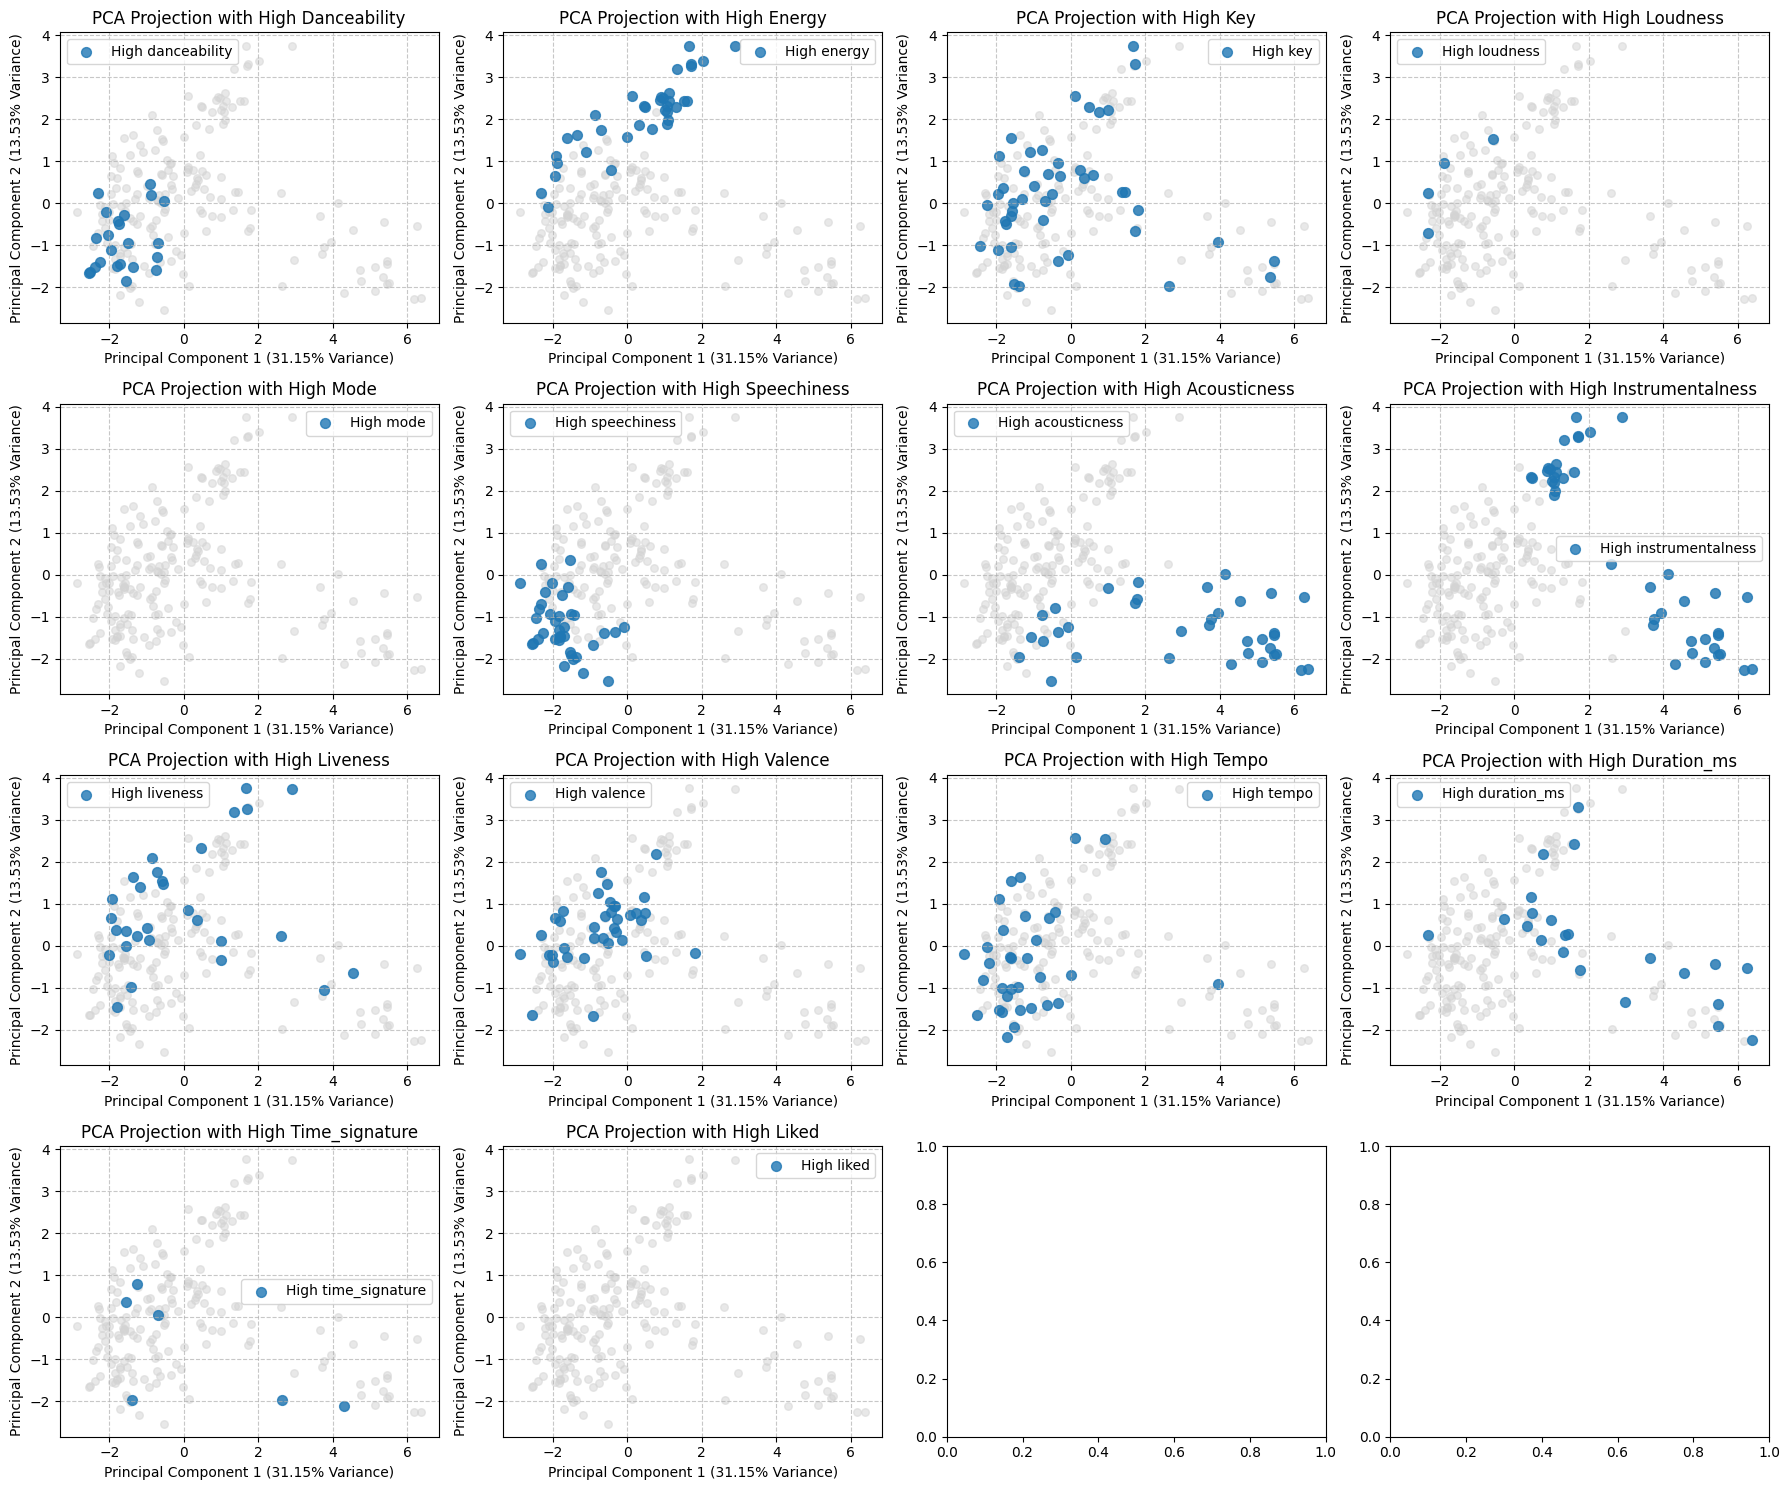

In [32]:
def perform_pca_analysis():
    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features_standardized)

    # Print explained variance
    print("PCA explained variance ratio:", pca.explained_variance_ratio_)
    print("Total variance explained:", sum(pca.explained_variance_ratio_))

    # Basic PCA visualization
    plt.figure(figsize=(8, 6))
    
    # Use liked/disliked labels for coloring
    scatter = plt.scatter(pca_result[liked == 1, 0], pca_result[liked == 1, 1], 
                          c='red', alpha=0.6, s=20, label='Liked')
    scatter = plt.scatter(pca_result[liked == 0, 0], pca_result[liked == 0, 1], 
                          c='blue', alpha=0.6, s=20, label='Not Liked')

    plt.title('PCA-Projektion der Musikdaten')
    plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} Varianz)')
    plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} Varianz)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig('Documentation/resources/images/pca_visualization.png', dpi=300)
    plt.show()

    # Analyze PCA loadings
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=['PC1', 'PC2'],
        index=song_features
    )
    print("\nPCA Loadings:")
    print(loadings)

    # Visualize loadings
    plt.figure(figsize=(12, 8))
    plt.barh(song_features, loadings['PC1'], color='blue', alpha=0.6, label='PC1')
    plt.barh(song_features, loadings['PC2'], color='red', alpha=0.6, label='PC2')
    plt.xlabel('Contribution to Principal Component')
    plt.title('Feature Loadings for Principal Components')
    plt.legend()
    plt.tight_layout()
    plt.savefig('Documentation/resources/images/pca_loadings.png', dpi=300)
    plt.show()

    # Plot grid of charts with all features highlighted
    fig, axes = plt.subplots(4, 4, figsize=(18, 15))
    axes = axes.flatten()

    for i, feature in enumerate(song_features):
        high_feature = features_standardized[:, i] > 1.0  # Standardized value > 1.0
        axes[i].scatter(pca_result[:, 0], pca_result[:, 1], c='lightgray', alpha=0.5, s=30)
        axes[i].scatter(pca_result[high_feature, 0], pca_result[high_feature, 1], s=50, alpha=0.8, label=f'High {feature}')
        axes[i].set_title(f'PCA Projection with High {feature.capitalize()}')
        axes[i].set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} Variance)')
        axes[i].set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} Variance)')
        axes[i].grid(True, linestyle='--', alpha=0.7)
        axes[i].legend()

    plt.tight_layout()
    plt.savefig('Documentation/resources/images/pca_highlighted_features_grid.png', dpi=300)
    plt.show()
    
    return pca_result, pca

pca_result, pca = perform_pca_analysis()


 ## t-SNE Implementation and Visualization

In [33]:
def perform_tsne_analysis():
    # t-SNE with different perplexity values
    perplexities = [5, 30, 50, 100]
    tsne_results = {}

    plt.figure(figsize=(20, 15))

    for i, perplexity in enumerate(perplexities):
        start_time = time.time()
        tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=1000, random_state=42)
        tsne_result = tsne.fit_transform(features_standardized)
        end_time = time.time()
        execution_time = end_time - start_time
        
        tsne_results[perplexity] = tsne_result
        
        plt.subplot(2, 2, i+1)
        if liked is not None:
            scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], 
                                 c=liked, alpha=0.6, s=30, cmap='coolwarm')
            plt.colorbar(scatter, label='Liked (1) / Disliked (0)')
        else:
            scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.6, s=30)
        
        plt.title(f't-SNE (Perplexity={perplexity}, Zeit: {execution_time:.2f}s)')
        plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('Documentation/resources/images/tsne_perplexity_comparison.png', dpi=300)
    plt.show()
    
    # Use the best perplexity for further analysis
    best_perplexity = 50  # Choose the best perplexity based on visual inspection
    tsne_result = tsne_results[best_perplexity]

    # Plot grid of charts with all features highlighted
    fig, axes = plt.subplots(4, 4, figsize=(18, 15))
    axes = axes.flatten()

    for i, feature in enumerate(song_features):
        high_feature = features_standardized[:, i] > 1.0  # Standardized value > 1.0
        axes[i].scatter(tsne_result[:, 0], tsne_result[:, 1], c='lightgray', alpha=0.5, s=30)
        axes[i].scatter(tsne_result[high_feature, 0], tsne_result[high_feature, 1], s=50, alpha=0.8, label=f'High {feature}')
        axes[i].set_title(f't-SNE Projection with High {feature.capitalize()}')
        axes[i].set_xlabel('t-SNE Component 1')
        axes[i].set_ylabel('t-SNE Component 2')
        axes[i].grid(True, linestyle='--', alpha=0.7)
        axes[i].legend()

    plt.tight_layout()
    plt.savefig('Documentation/resources/images/tsne_highlighted_features_grid.png', dpi=300)
    plt.show()

    # If we have liked data, analyze the patterns
    if liked is not None:
        # Highlight liked songs
        plt.figure(figsize=(12, 10))
        # Plot all disliked songs
        plt.scatter(tsne_result[liked==0, 0], tsne_result[liked==0, 1], 
                  c='blue', alpha=0.5, s=30, label='Disliked')
        # Plot all liked songs
        plt.scatter(tsne_result[liked==1, 0], tsne_result[liked==1, 1], 
                  c='red', alpha=0.5, s=30, label='Liked')
        plt.title('t-SNE Projektion nach Liked/Disliked Status')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        plt.savefig('Documentation/resources/images/tsne_liked_disliked.png', dpi=300)
        plt.show()
        
    return tsne_result, best_perplexity


## PCA vs t-SNE Comparison

In [34]:
def compare_pca_tsne(pca_result, tsne_result, pca, best_perplexity):
    # Direct comparison between PCA and t-SNE
    plt.figure(figsize=(20, 10))
    
    # PCA plot
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], 
                         c=liked, alpha=0.6, s=30, cmap='coolwarm')
    plt.colorbar(scatter, label='Liked (1) / Disliked (0)')
    
    plt.title('PCA-Projektion')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} Varianz)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} Varianz)')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # t-SNE plot
    plt.subplot(1, 2, 2)
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], 
                         c=liked, alpha=0.6, s=30, cmap='coolwarm')
    plt.colorbar(scatter, label='Liked (1) / Disliked (0)')
    
    plt.title(f't-SNE-Projektion (Perplexity={best_perplexity})')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('Documentation/resources/images/pca_vs_tsne.png', dpi=300)
    plt.show()
    
    # Analyze feature importance in PCA
    loadings = pd.DataFrame(
        data=pca.components_.T,
        columns=['PC1', 'PC2'],
        index=song_features
    )
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
    plt.title('PCA Feature Loadings Heatmap')
    plt.tight_layout()
    plt.savefig('Documentation/resources/images/pca_loadings_heatmap.png', dpi=300)
    plt.show()
    
    # Feature importance visualization
    plt.figure(figsize=(14, 8))
    features_importance = pd.DataFrame({
        'Feature': song_features,
        'PC1 Loading': np.abs(pca.components_[0]),
        'PC2 Loading': np.abs(pca.components_[1])
    })
    
    features_importance = features_importance.sort_values('PC1 Loading', ascending=False)
    
    ax = features_importance.plot(x='Feature', y='PC1 Loading', kind='bar', 
                                 color='blue', alpha=0.7, figsize=(14, 8))
    plt.title('Feature Importance in PC1')
    plt.xlabel('Features')
    plt.ylabel('Absolute Loading Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('Documentation/resources/images/pca_feature_importance.png', dpi=300)
    plt.show()

## Testing pgvector Similarity Search

In [35]:
def test_similarity_search():
    conn = connect_to_postgres()
    cursor = conn.cursor()
    
    # Pick a random song
    random_index = np.random.randint(0, len(features))
    sample_vector = features[random_index]
    
    print(f"Finding similar songs to song #{random_index+1}")
    
    vector_str = str(sample_vector.tolist()).replace('[', '').replace(']', '')
    
    # First, let's check the structure of our table to ensure we're using the correct column names
    cursor.execute("SELECT column_name, data_type FROM information_schema.columns WHERE table_name = 'music_vectors'")
    columns = cursor.fetchall()
    print("\nTable structure:")
    for col in columns:
        print(f"Column: {col[0]}, Type: {col[1]}")
    
    # Query for similar songs using L2 distance (without referencing 'liked' directly)
    try:
        cursor.execute(f"""
        SELECT id, features <-> '{vector_str}' AS distance
        FROM music_vectors
        WHERE id != %s
        ORDER BY distance
        LIMIT 5
        """, (random_index + 1,))  # Adding 1 because SQL IDs start at 1
        
        similar_songs = cursor.fetchall()
        
        print("\nMost similar songs (L2 distance):")
        for song in similar_songs:
            print(f"ID: {song[0]}, Distance: {song[1]:.4f}")
        
        # Now try to get liked status if it exists
        try:
            cursor.execute(f"""
            SELECT id, liked, features <-> '{vector_str}' AS distance
            FROM music_vectors
            WHERE id != %s
            ORDER BY distance
            LIMIT 5
            """, (random_index + 1,))
            
            similar_songs_with_liked = cursor.fetchall()
            
            print("\nMost similar songs with liked status:")
            for song in similar_songs_with_liked:
                print(f"ID: {song[0]}, Liked: {song[1]}, Distance: {song[2]:.4f}")
        except Exception as e:
            print(f"Error when querying with liked column: {e}")
        
        # Query for similar songs using Cosine distance
        cursor.execute(f"""
        SELECT id, 1 - (features <=> '{vector_str}') AS similarity
        FROM music_vectors
        WHERE id != %s
        ORDER BY similarity DESC
        LIMIT 5
        """, (random_index + 1,))
        
        similar_songs_cosine = cursor.fetchall()
        
        print("\nMost similar songs (Cosine similarity):")
        for song in similar_songs_cosine:
            print(f"ID: {song[0]}, Similarity: {song[1]:.4f}")
        
    except Exception as e:
        print(f"Error in similarity search: {e}")
    finally:
        cursor.close()
        conn.close()


## Create a Cluster Analysis

In [36]:
def cluster_analysis():
    from sklearn.cluster import KMeans
    
    # Try different numbers of clusters
    wcss = []  # Within-Cluster Sum of Squares
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
        kmeans.fit(features_standardized)
        wcss.append(kmeans.inertia_)
    
    # Plot the Elbow Method graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), wcss, marker='o', linestyle='-')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.grid(True)
    plt.savefig('Documentation/resources/images/elbow_method.png', dpi=300)
    plt.show()
    
    # Choose optimal number of clusters (let's say it's 4 based on elbow method)
    optimal_clusters = 4
    kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(features_standardized)
    
    # PCA visualization with clusters
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features_standardized)
    
    plt.figure(figsize=(12, 10))
    for i in range(optimal_clusters):
        plt.scatter(pca_result[cluster_labels == i, 0], pca_result[cluster_labels == i, 1], 
                   s=50, label=f'Cluster {i+1}')
    plt.title('PCA mit K-Means Clustering')
    plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} Varianz)')
    plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} Varianz)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('Documentation/resources/images/pca_kmeans_clusters.png', dpi=300)
    plt.show()
    
    # t-SNE visualization with clusters
    tsne = TSNE(n_components=2, perplexity=50, n_iter=1000, random_state=42)
    tsne_result = tsne.fit_transform(features_standardized)
    
    plt.figure(figsize=(12, 10))
    for i in range(optimal_clusters):
        plt.scatter(tsne_result[cluster_labels == i, 0], tsne_result[cluster_labels == i, 1], 
                   s=50, label=f'Cluster {i+1}')
    plt.title('t-SNE mit K-Means Clustering')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('Documentation/resources/images/tsne_kmeans_clusters.png', dpi=300)
    plt.show()
    
    # Analyze cluster characteristics
    cluster_data = pd.DataFrame(features, columns=song_features)
    cluster_data['cluster'] = cluster_labels
    cluster_data['liked'] = liked
    
    cluster_summary = cluster_data.groupby('cluster').mean()
    print("\nCluster Characteristics:")
    print(cluster_summary)
    
    # Visualize cluster profiles
    plt.figure(figsize=(14, 8))
    cluster_summary[song_features].plot(kind='bar', figsize=(14, 8))
    plt.title('Music Feature Profiles by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Average Feature Value')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    plt.tight_layout()
    plt.savefig('Documentation/resources/images/cluster_profiles.png', dpi=300)
    plt.show()
    
    # Liked ratio by cluster
    liked_ratio = cluster_data.groupby('cluster')['liked'].mean()
    
    plt.figure(figsize=(10, 6))
    liked_ratio.plot(kind='bar', color='skyblue')
    plt.title('Proportion of Liked Songs by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Liked Ratio')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('Documentation/resources/images/liked_ratio_by_cluster.png', dpi=300)
    plt.show()
    
    return cluster_labels, optimal_clusters


# Main controll script


Running PCA analysis...
PCA explained variance ratio: [0.31148714 0.13533981]
Total variance explained: 0.4468269493017223


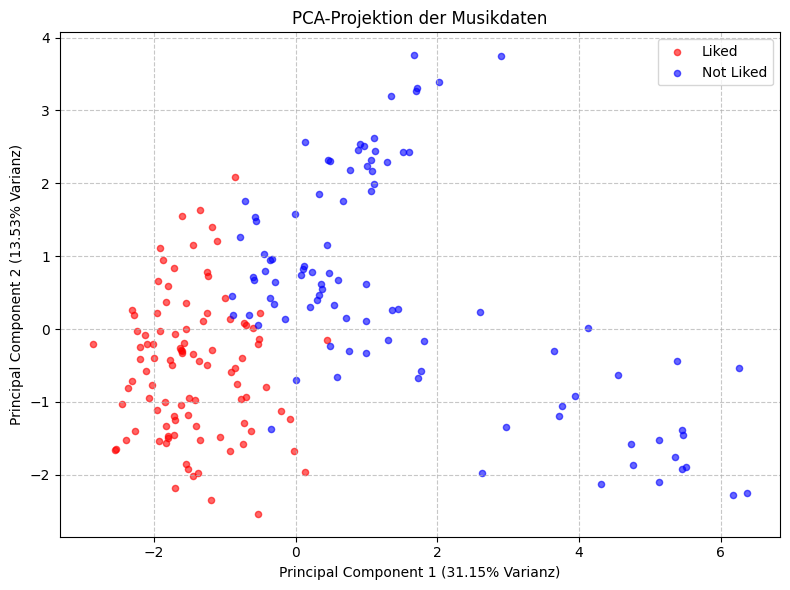


PCA Loadings:
                       PC1       PC2
danceability     -0.365448 -0.263611
energy           -0.287791  0.523091
key              -0.012096  0.193376
loudness         -0.377983  0.310844
mode              0.009612 -0.092453
speechiness      -0.260287 -0.295518
acousticness      0.287671 -0.463158
instrumentalness  0.386928  0.173710
liveness         -0.012048  0.236684
valence          -0.302091 -0.015152
tempo            -0.232009 -0.035324
duration_ms       0.210979  0.178345
time_signature   -0.182744 -0.094117
liked            -0.342281 -0.290062


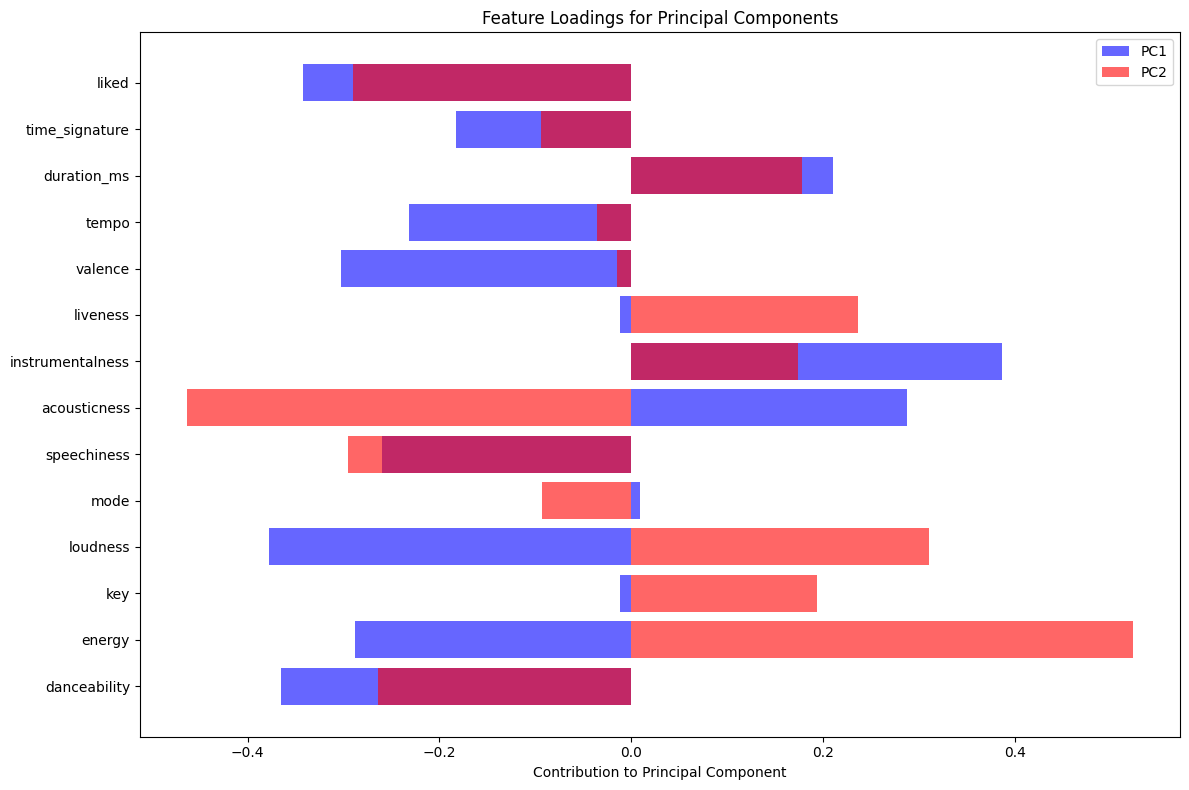

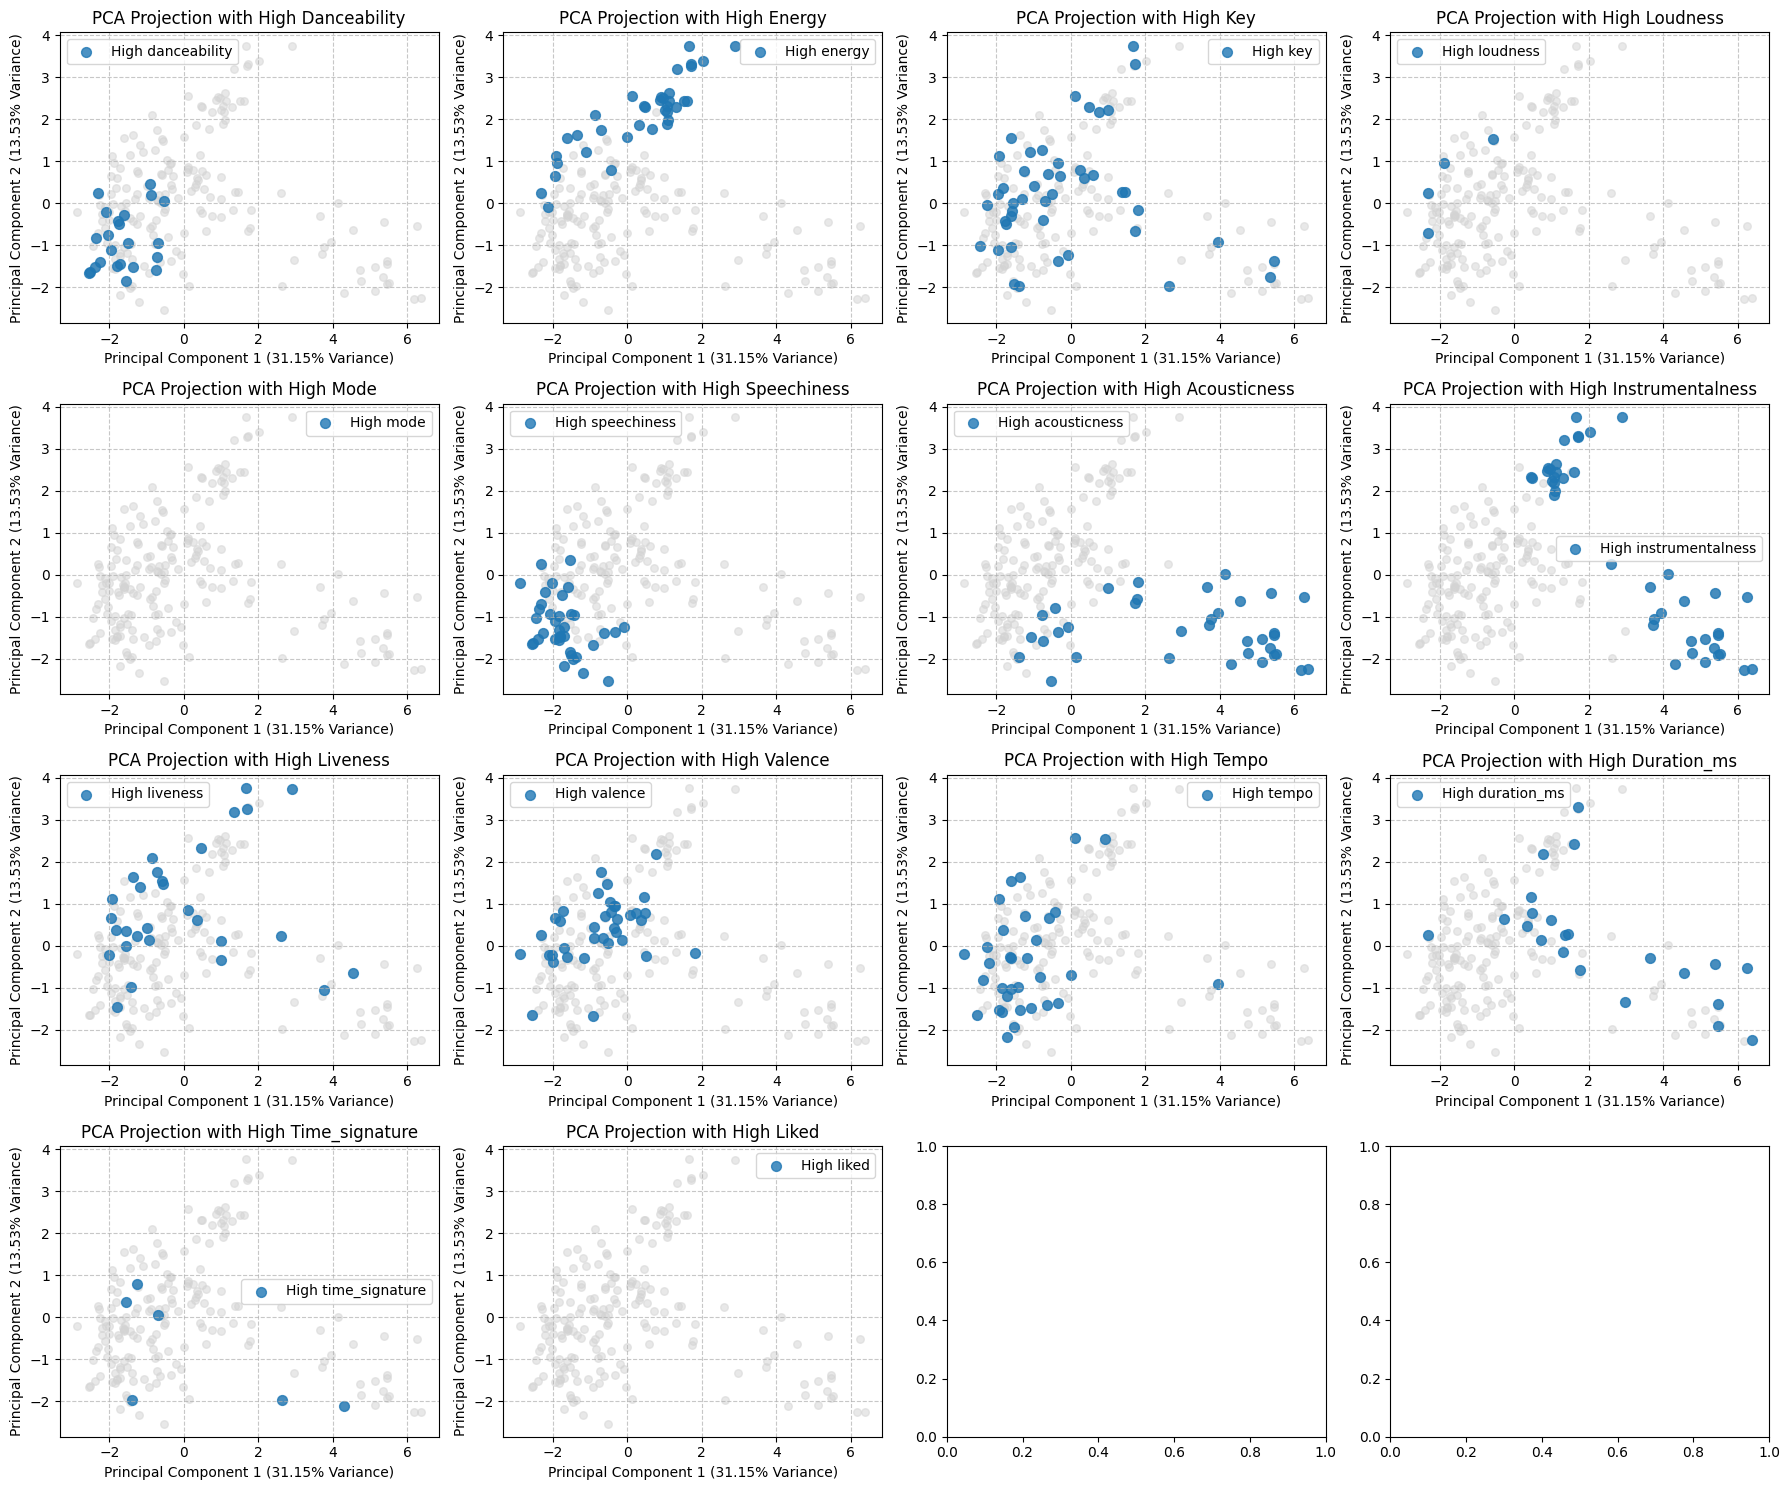


Running t-SNE analysis...


c:\Users\rorba\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\rorba\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\rorba\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\rorba\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


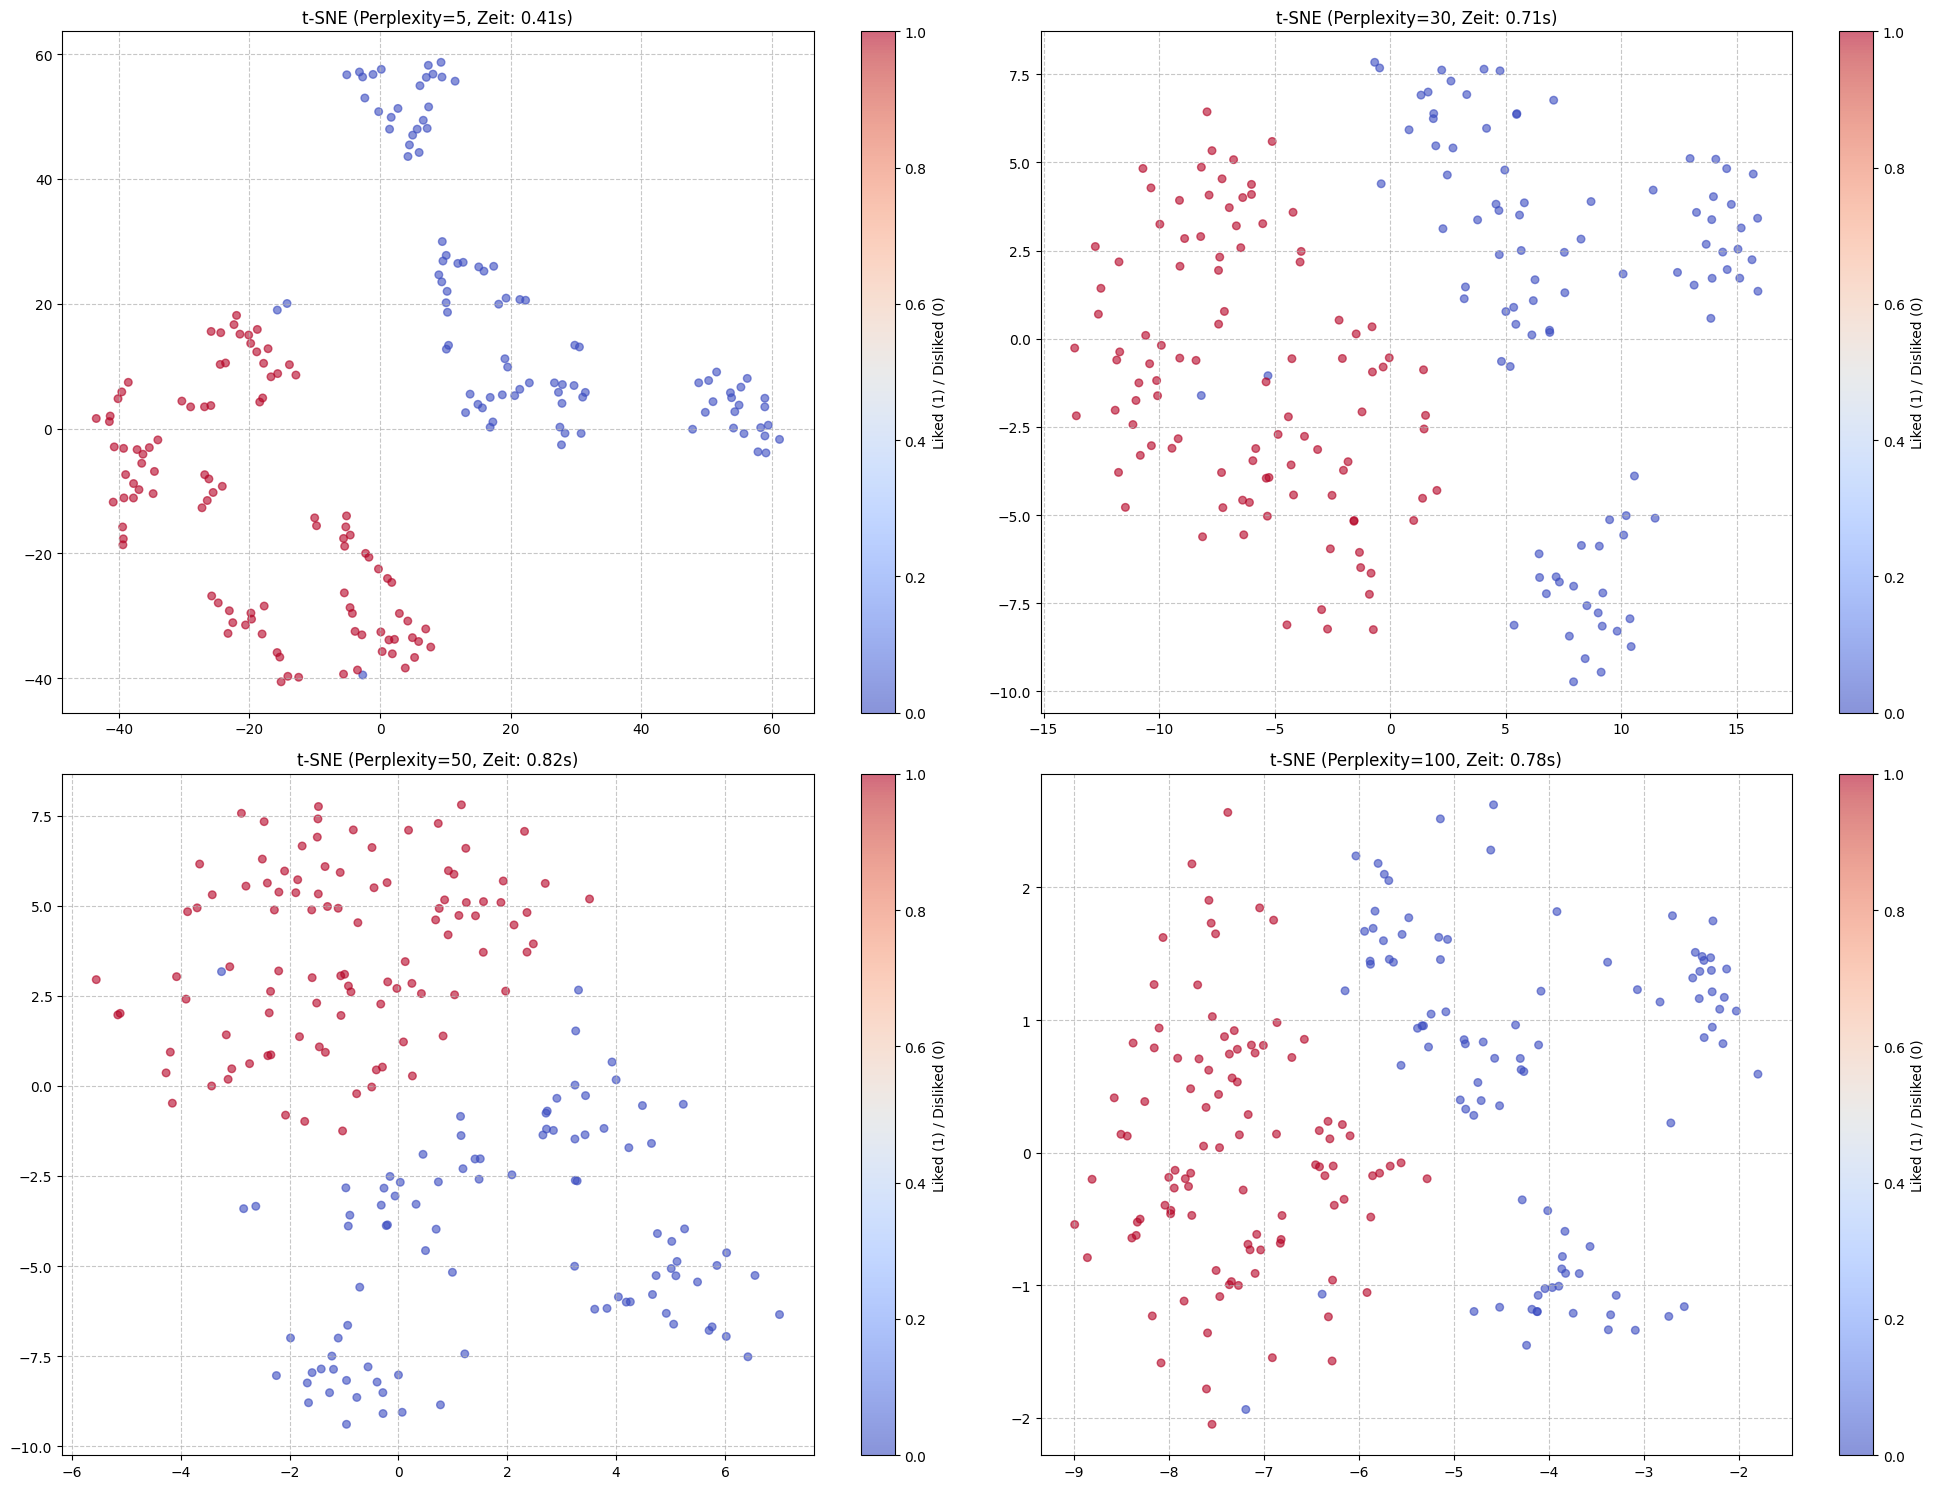

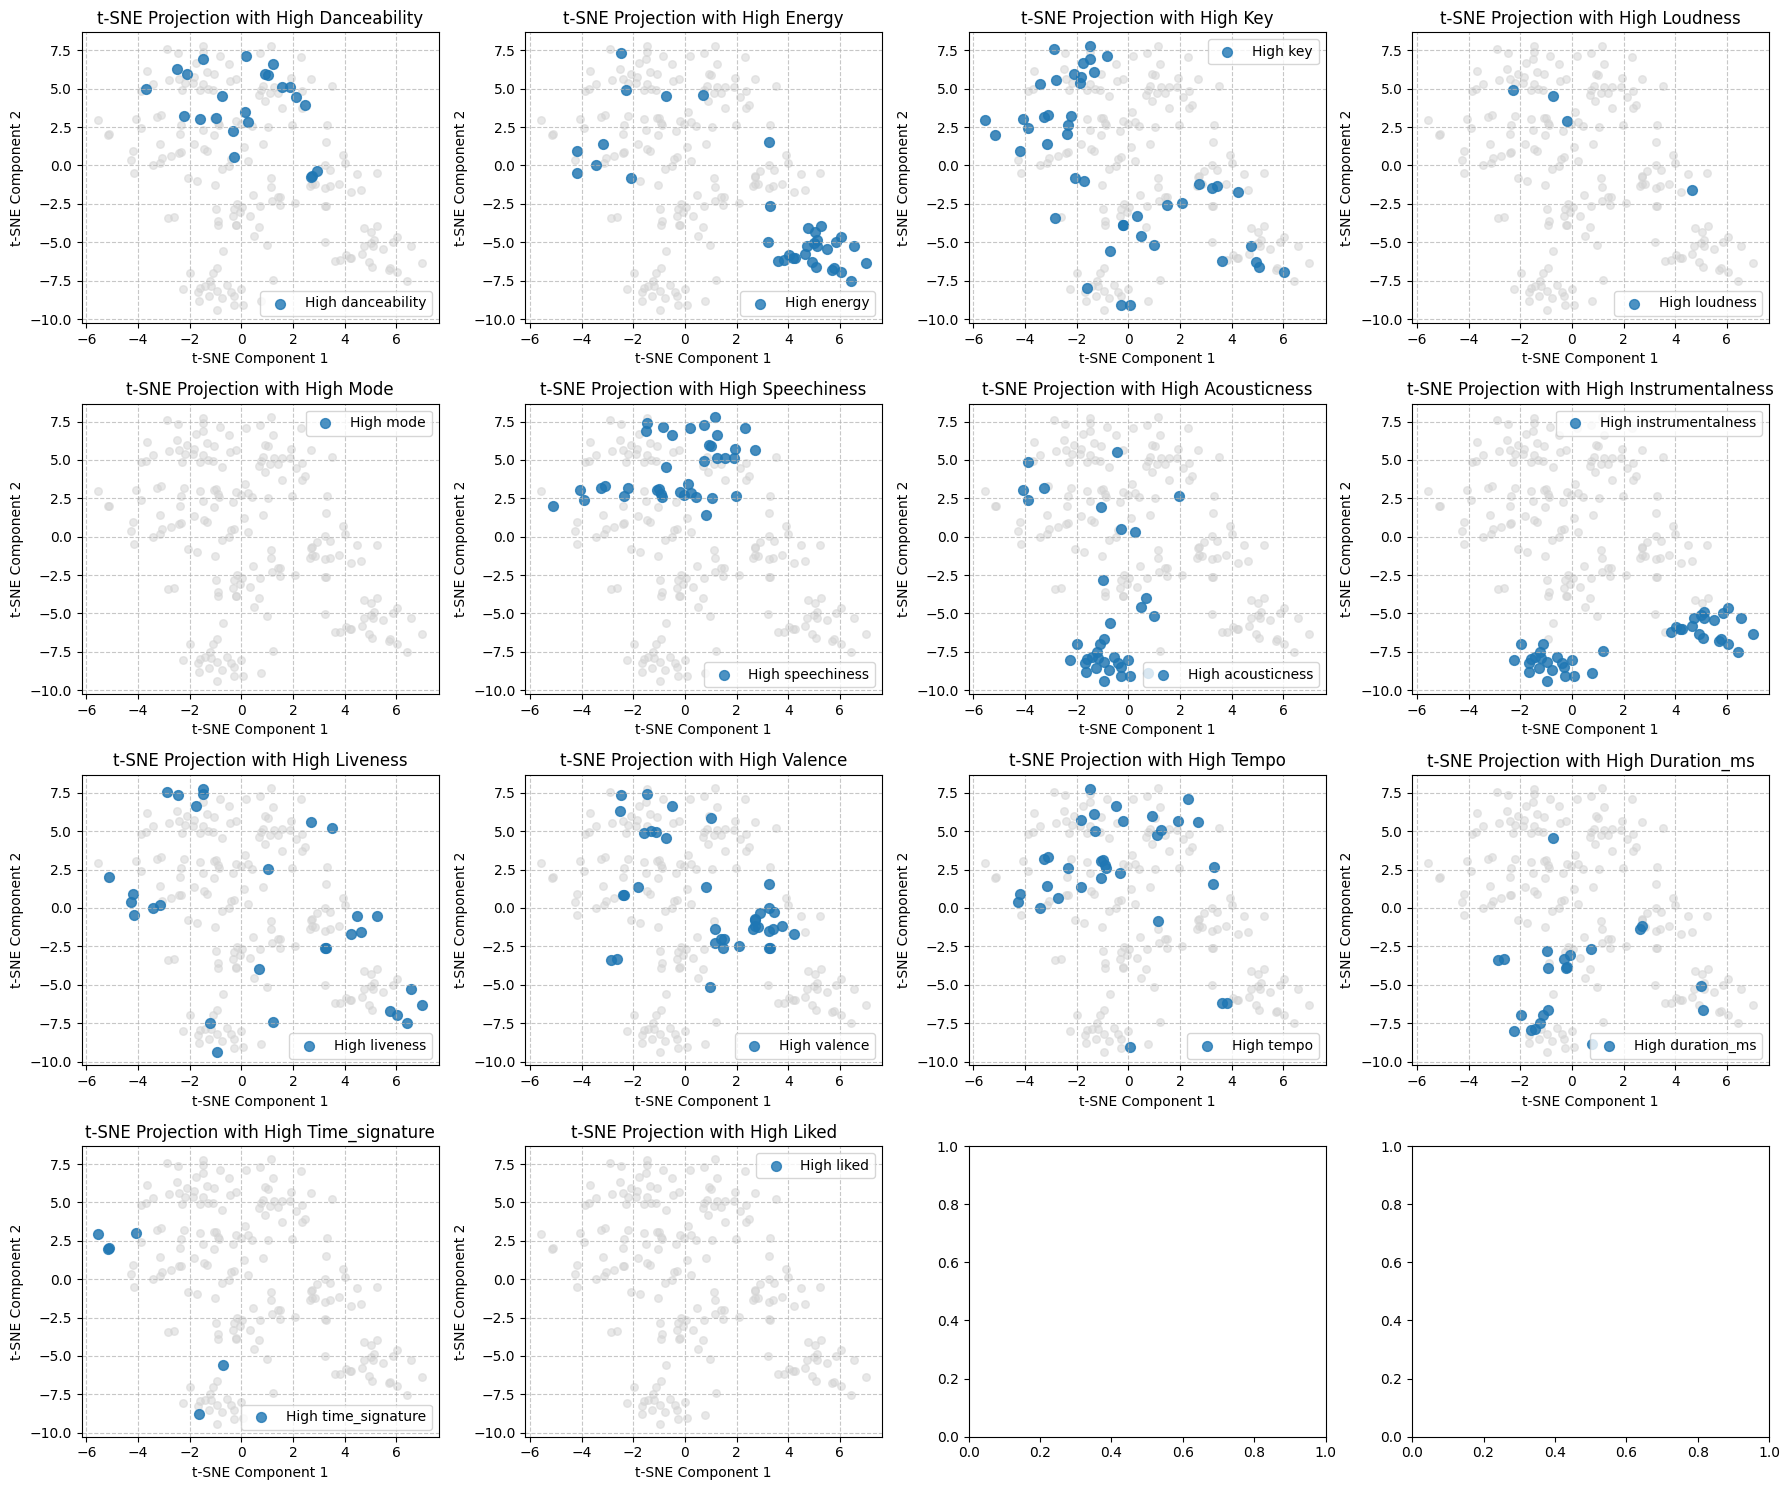

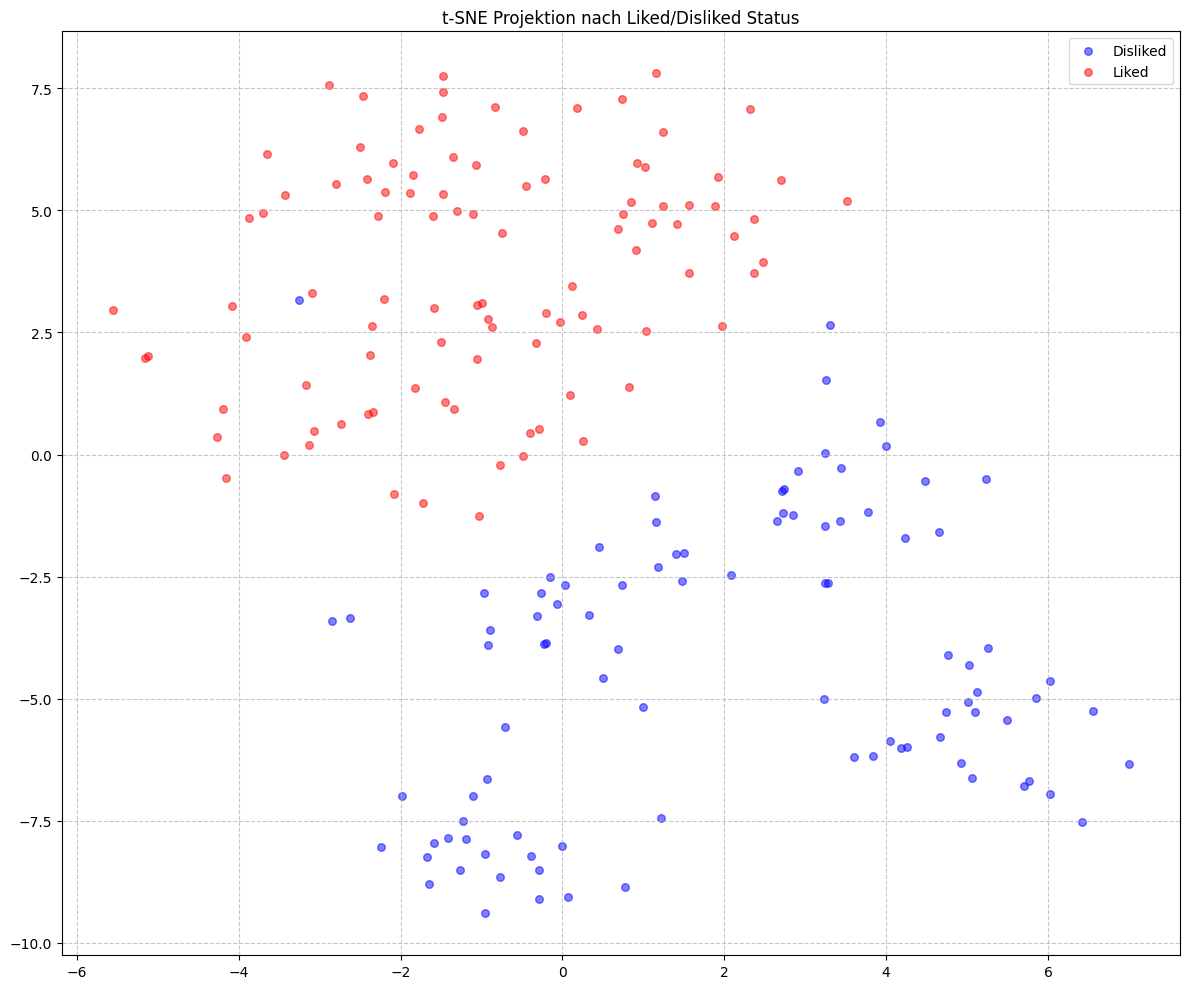


Comparing PCA and t-SNE...


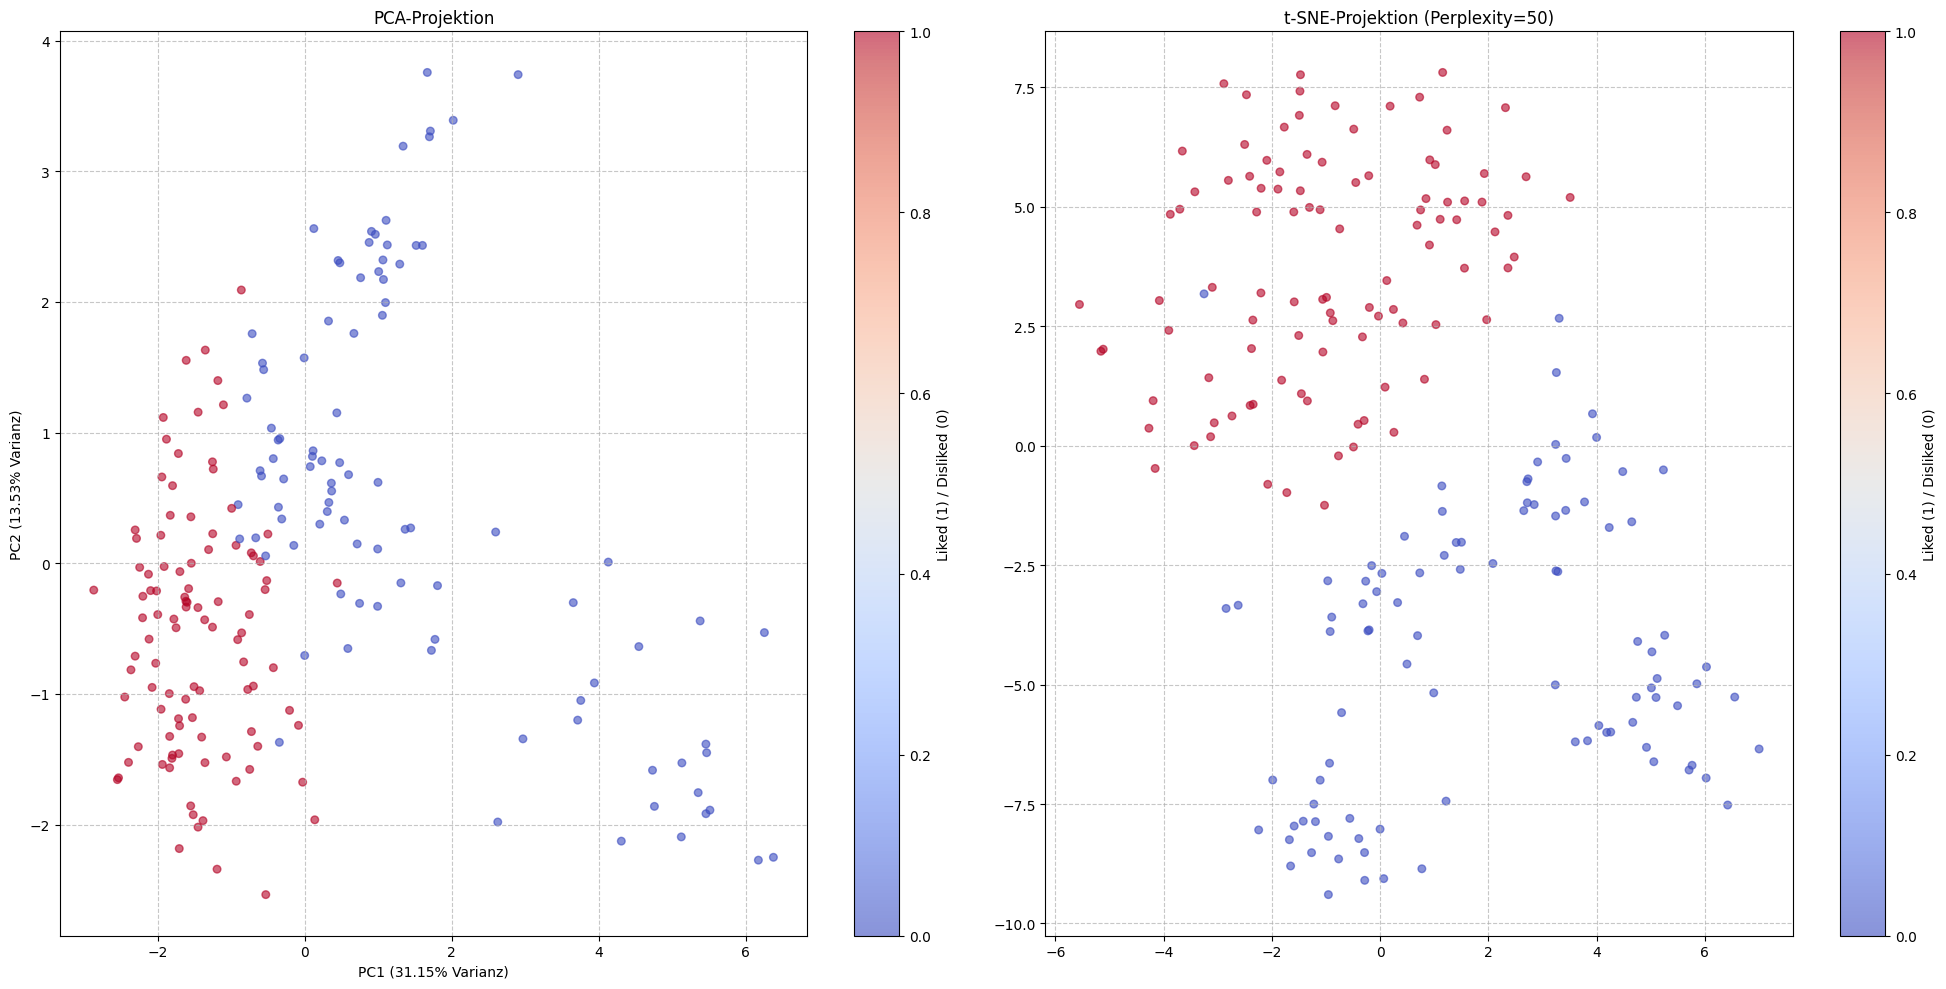

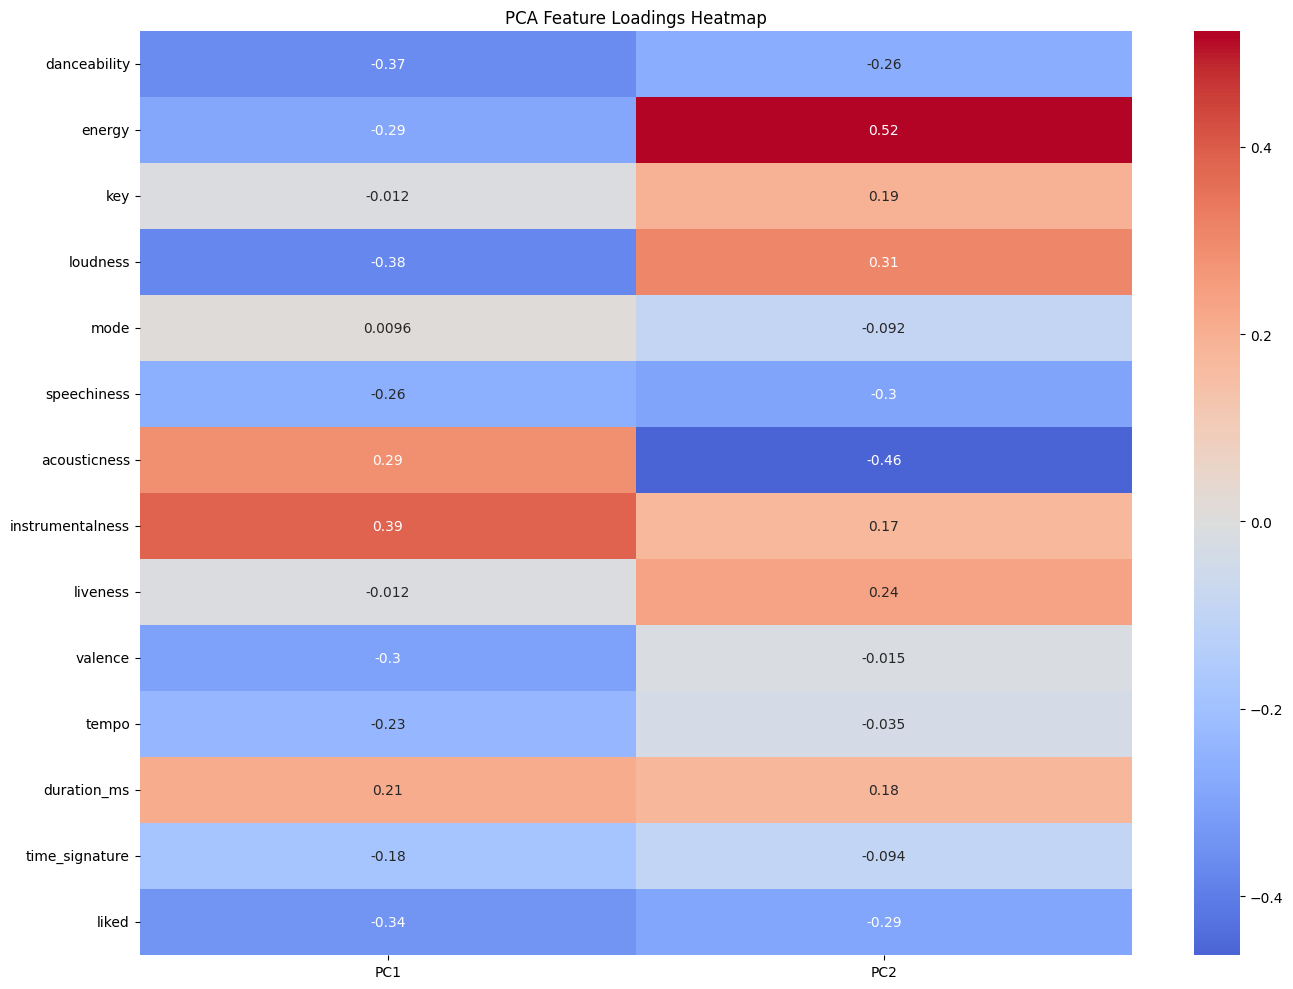

<Figure size 1400x800 with 0 Axes>

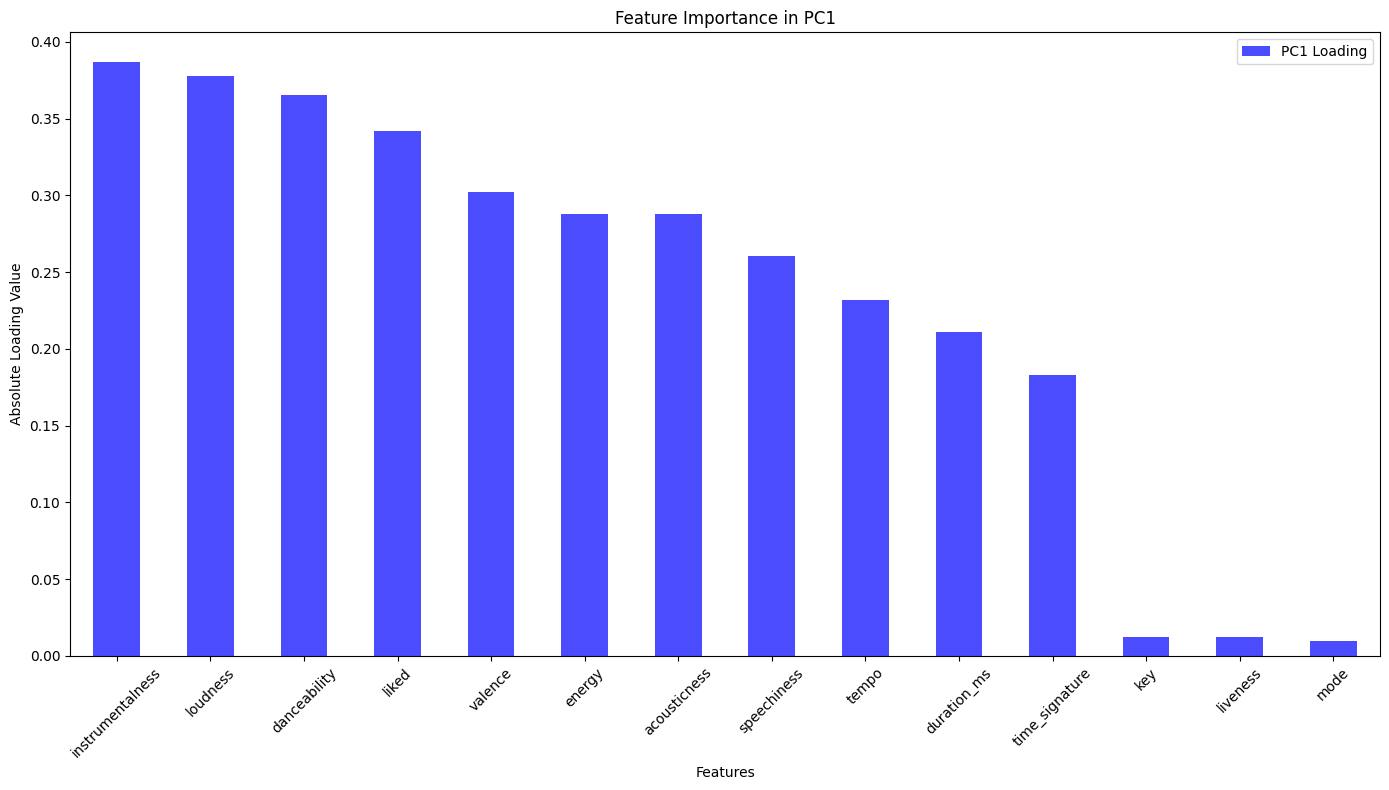


Testing pgvector similarity search...
Finding similar songs to song #96

Table structure:
Column: id, Type: integer
Column: features, Type: USER-DEFINED
Error in similarity search: malformed vector literal: "0.783, 0.836, 0.0, -9.223, 0.0, 0.0486, 0.396, 0.0236, 0.135, 0.831, 108.966, 222667.0, 4.0, 0.0"
LINE 2:         SELECT id, features <-> '0.783, 0.836, 0.0, -9.223, ...
                                        ^
DETAIL:  Vector contents must start with "[".


Performing cluster analysis...


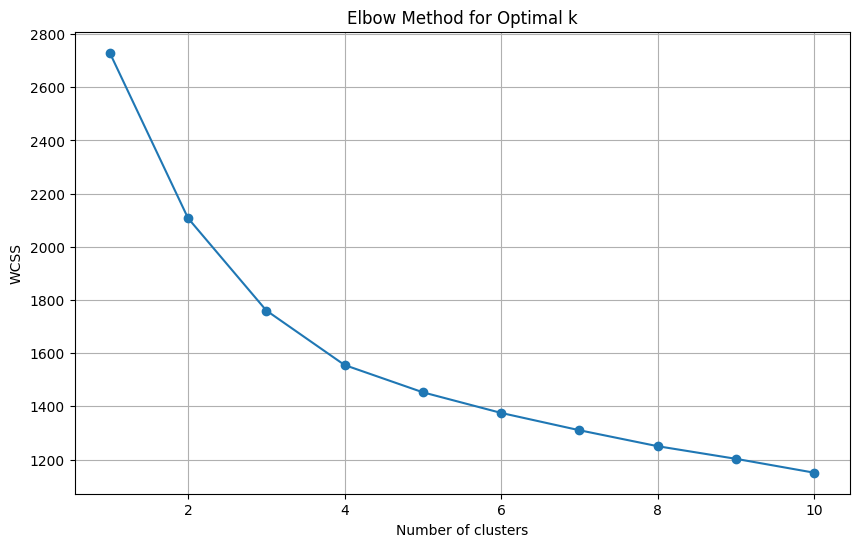

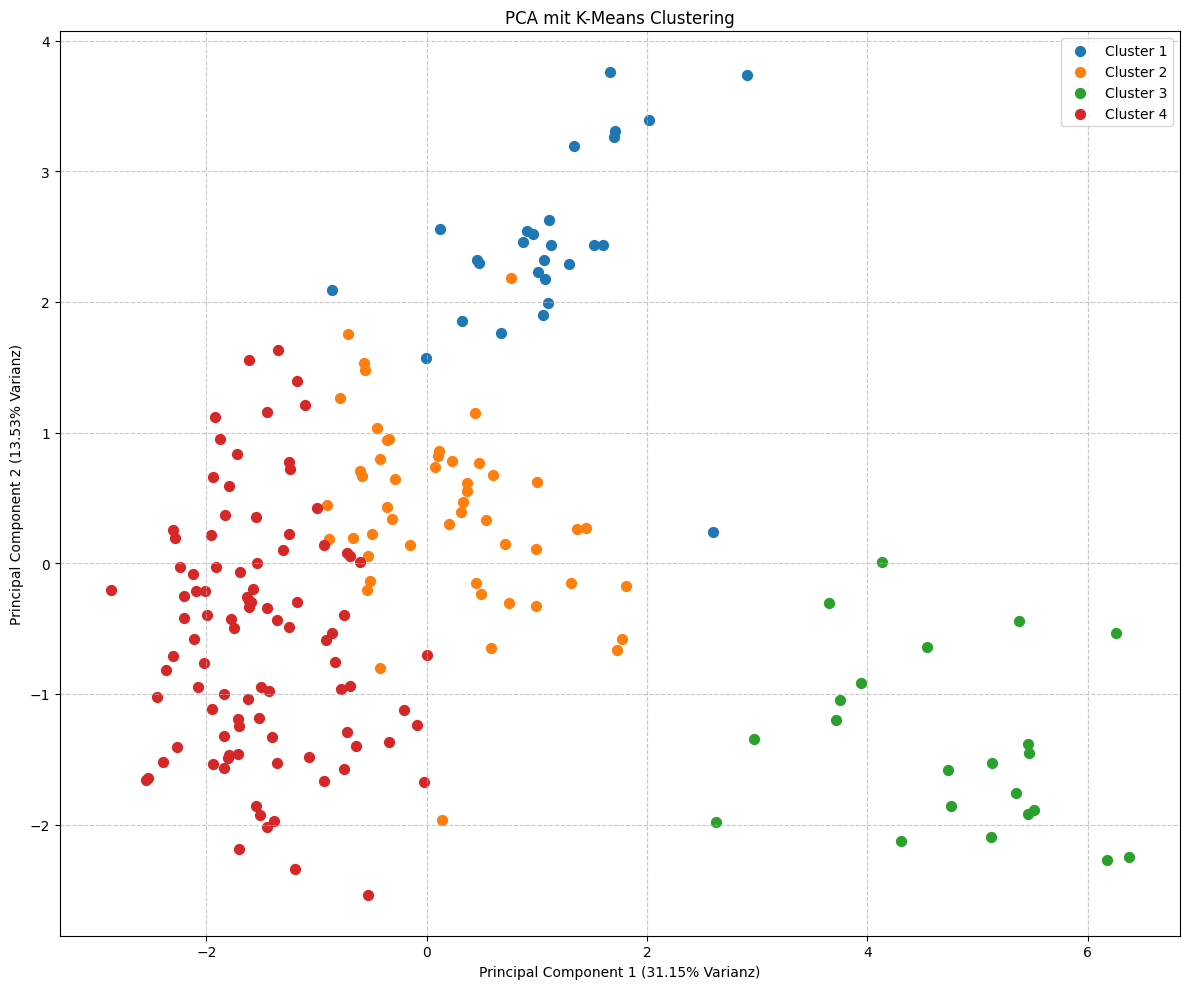

c:\Users\rorba\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


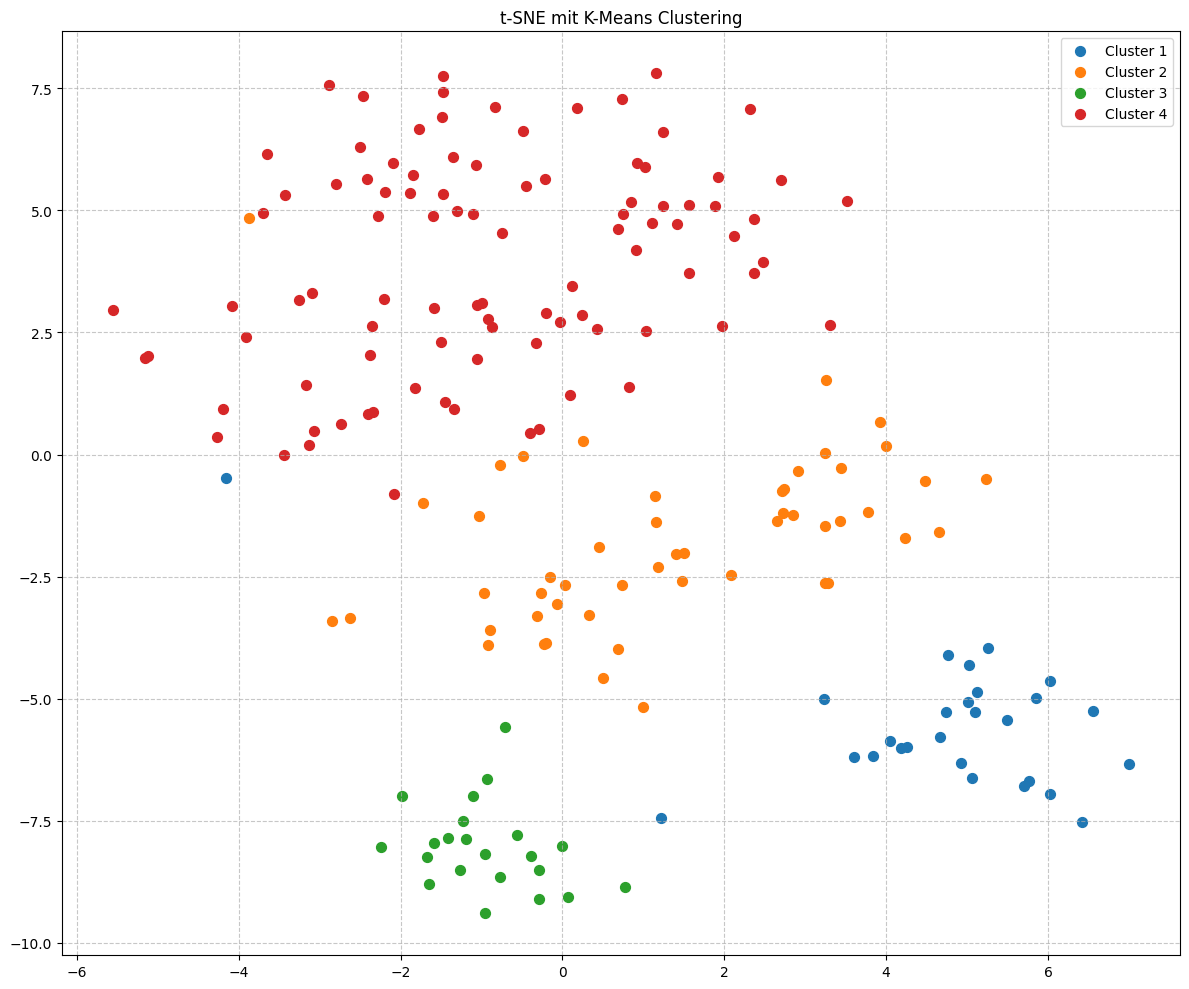


Cluster Characteristics:
         danceability    energy       key   loudness      mode  speechiness  \
cluster                                                                       
0            0.329037  0.950370  5.777778  -6.629111  0.444444     0.110422   
1            0.716510  0.628804  5.784314  -9.110588  0.431373     0.061102   
2            0.302136  0.093370  5.000000 -24.821000  0.727273     0.044818   
3            0.758684  0.681168  5.378947  -6.939263  0.578947     0.231191   

         acousticness  instrumentalness  liveness   valence       tempo  \
cluster                                                                   
0            0.018693          0.670505  0.202100  0.274333  113.333259   
1            0.314437          0.026666  0.137449  0.628571  108.789333   
2            0.960636          0.817268  0.123064  0.121650  100.016545   
3            0.258401          0.000655  0.144998  0.569661  134.770379   

           duration_ms  time_signature     liked

<Figure size 1400x800 with 0 Axes>

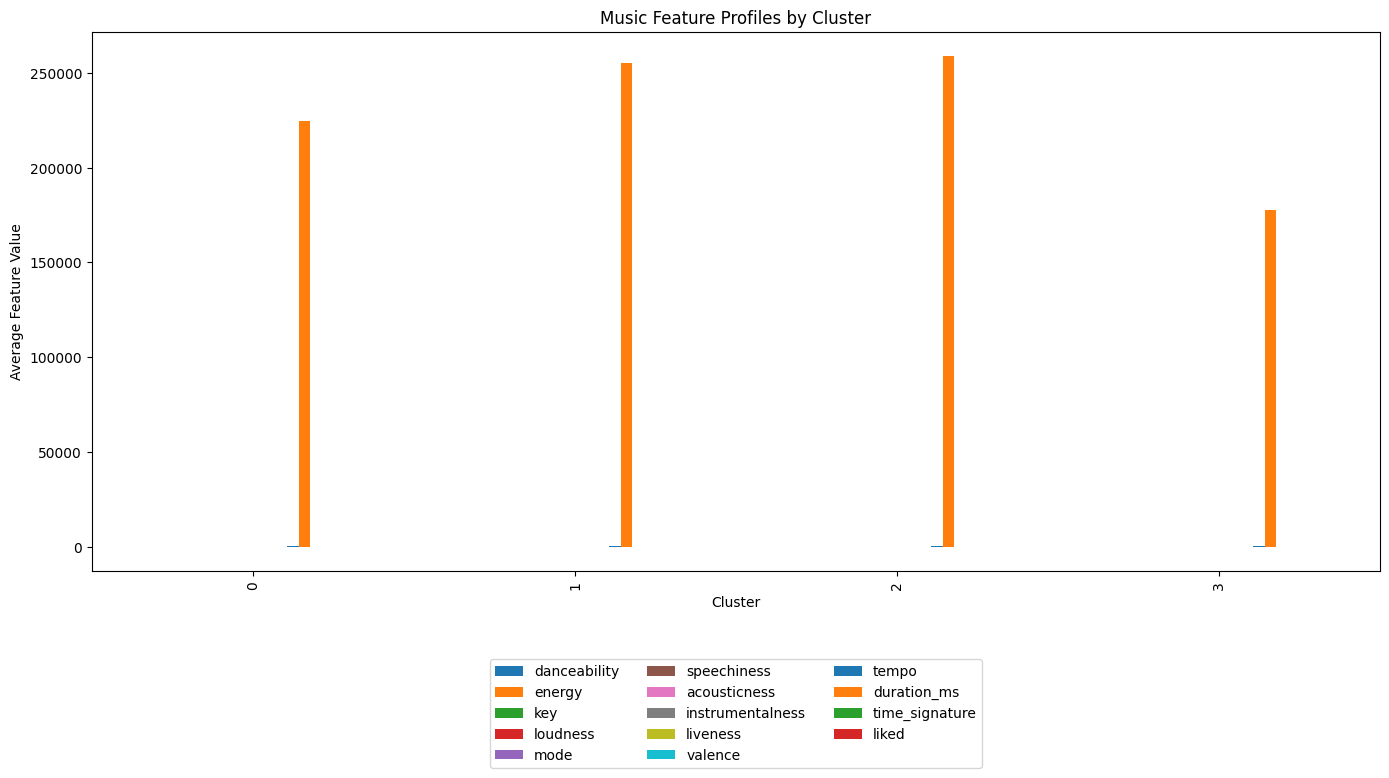

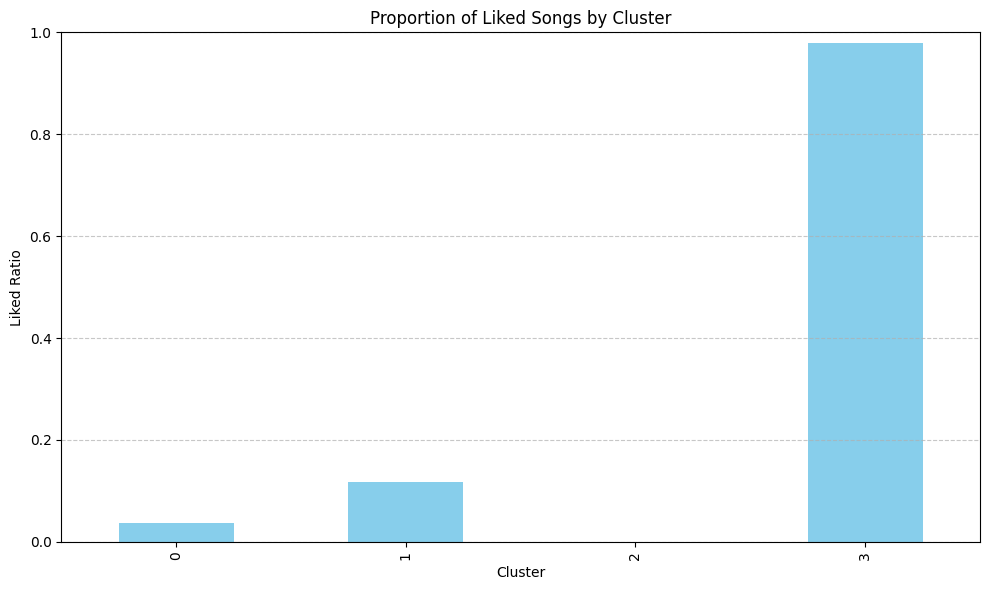


All analyses complete!


In [37]:
def main():
    print("\nRunning PCA analysis...")
    pca_result, pca = perform_pca_analysis()
    
    print("\nRunning t-SNE analysis...")
    tsne_result, best_perplexity = perform_tsne_analysis()
    
    print("\nComparing PCA and t-SNE...")
    compare_pca_tsne(pca_result, tsne_result, pca, best_perplexity)
    
    print("\nTesting pgvector similarity search...")
    test_similarity_search()
    
    print("\nPerforming cluster analysis...")
    cluster_labels, optimal_clusters = cluster_analysis()
    
    print("\nAll analyses complete!")

# Run the main function
if __name__ == "__main__":
    main()
